In [1]:
import deepchem as dc
import pandas as pd
import numpy as np
from rdkit import Chem

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,KFold

from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
import shap
shap.initjs()

In [3]:
data = pd.read_csv('../../data/GABAA.csv',encoding='gb18030')

# Feature extraction & Data splitting

In [4]:
featurizer = dc.feat.MACCSKeysFingerprint()
features = featurizer.featurize(data['smiles'])
#dataset = dc.data.NumpyDataset(features,data['class'])

In [5]:
from sklearn.feature_selection import VarianceThreshold

# 初始化VarianceThreshold对象
vt = VarianceThreshold(threshold = (.98 * (1 - .98)))

# 进行特征选择
X_new = vt.fit_transform(features)
dataset = dc.data.NumpyDataset(X_new,data['class'])

In [6]:
splitter = dc.splits.RandomSplitter()
train_dataset, test_dataset = splitter.train_test_split(dataset=dataset,frac_train=0.8,seed=400)

In [7]:
data_maccs_mask = vt.get_support(indices=True)

# GridSearchCV

In [8]:
scoring = {
         'AUC':make_scorer(roc_auc_score, needs_proba=True),
          'ACC':make_scorer(accuracy_score),
           'PRE':make_scorer(precision_score),
           'REC':make_scorer(recall_score),
}


param_grid = {'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100], 
              'kernel': ['linear', 'rbf','poly'],
             'gamma':[0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.6, 0.7, 0.8, 0.8, 0.9, 1]
             }
    
svm_classifier = SVC(probability=True)

gs = GridSearchCV(
                    svm_classifier,
                   param_grid,
                 scoring = scoring,
                  cv = KFold(n_splits=5, shuffle=True, random_state=400),
                 n_jobs = -1,
               refit = 'AUC',
               return_train_score = True)

gs_fit = gs.fit(train_dataset.X, train_dataset.y.ravel())

In [9]:
val_AUC = gs.best_score_
val_ACC = gs.cv_results_['mean_test_ACC'][gs.best_index_]
val_PRE = gs.cv_results_['mean_test_PRE'][gs.best_index_]
val_REC = gs.cv_results_['mean_test_REC'][gs.best_index_]

# GridSearchCV_Result

In [10]:
print('Best parameters: ', gs.best_params_)
print('Best score (AUC): ', gs.best_score_)
print('ACC: ',gs.cv_results_['mean_test_ACC'][gs.best_index_])
print('PRE: ',gs.cv_results_['mean_test_PRE'][gs.best_index_])
print('REC: ',gs.cv_results_['mean_test_REC'][gs.best_index_])

Best parameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score (AUC):  0.9425238839628648
ACC:  0.8692307692307691
PRE:  0.8543551929258111
REC:  0.902238400661543


In [11]:
model = gs_fit.best_estimator_
model

SVC(C=1, gamma=0.1, probability=True)

# Evaluate model

In [12]:
y_test_pred_proba = model.predict_proba(test_dataset.X)
y_test_pred = model.predict(test_dataset.X)

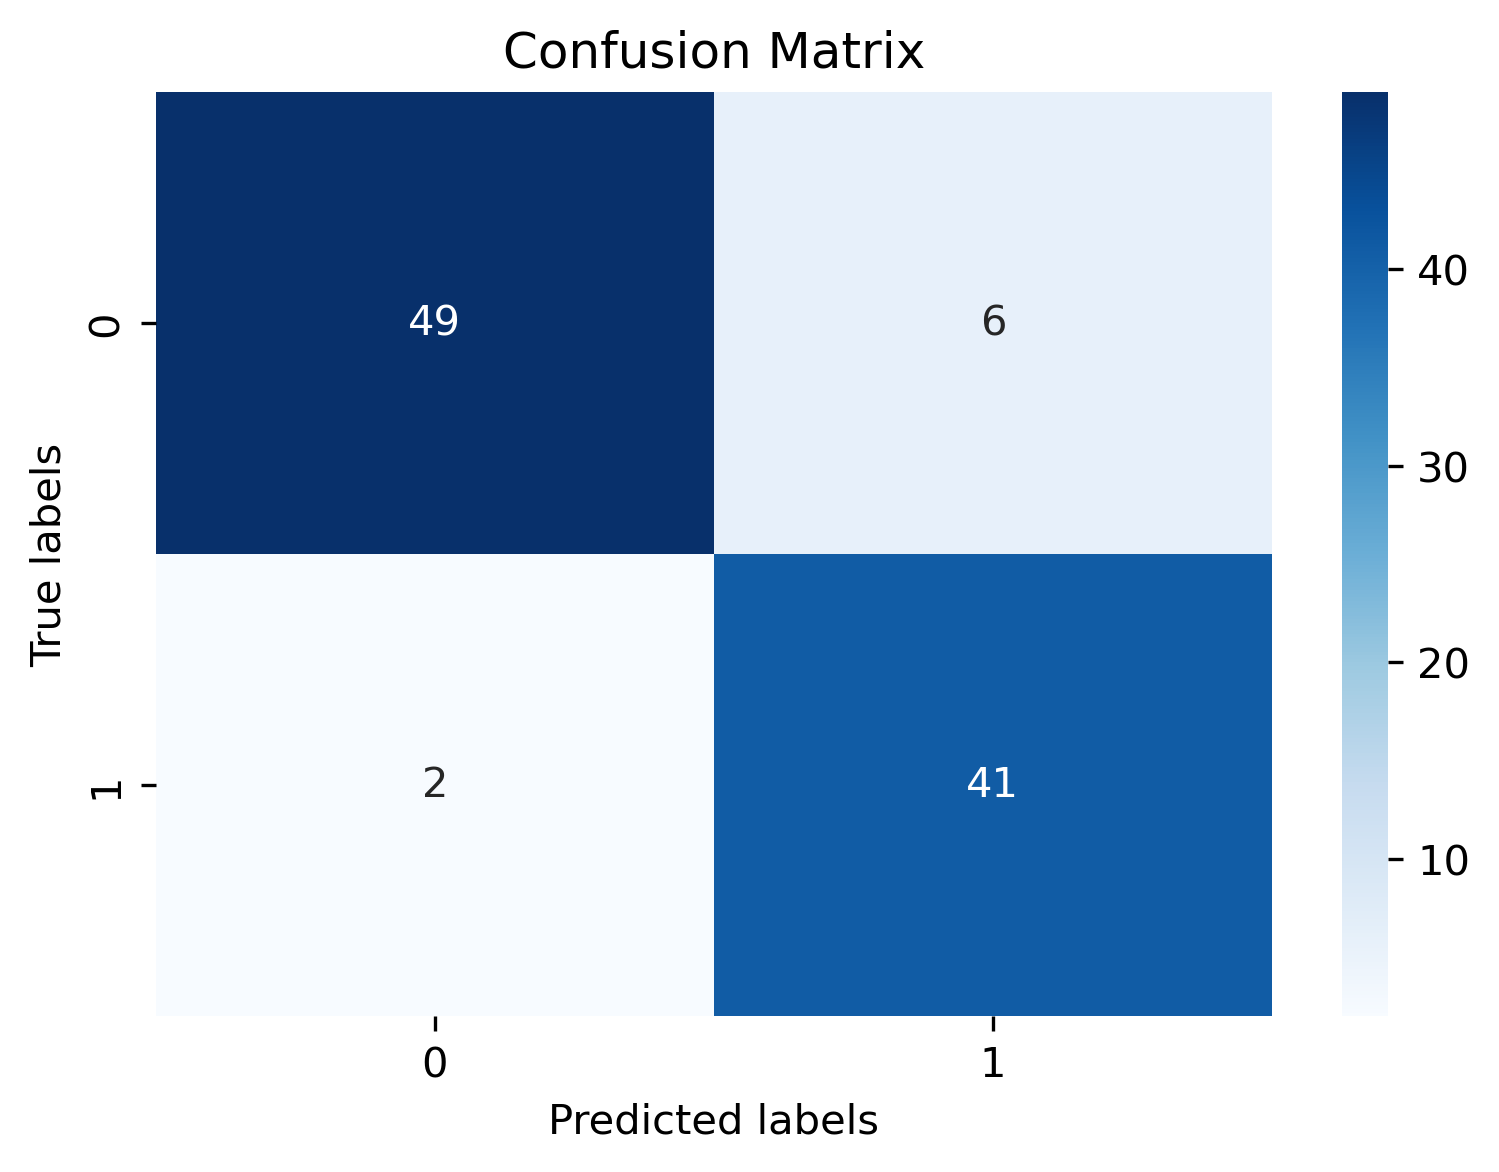

In [13]:
confusion_mat = confusion_matrix(test_dataset.y, y_test_pred)
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [14]:
test_pred_list = []
for test_score in y_test_pred_proba:
    test_score = test_score[1]
    test_pred_list.append(test_score)

In [15]:
test_pred_array = np.array(test_pred_list)

In [16]:
test_AUC = roc_auc_score(test_dataset.y,test_pred_list)
test_ACC = accuracy_score(test_dataset.y,np.round(test_pred_array))
test_PRE = precision_score(test_dataset.y,np.round(test_pred_array))
test_REC = recall_score(test_dataset.y,np.round(test_pred_array))

# Finall result

In [17]:
performance_dataset = {
    'AUC':[val_AUC,test_AUC],
    'ACC':[val_ACC,test_ACC],
    'PRE':[val_PRE,test_PRE],
    'REC':[val_REC,test_REC]
}

In [18]:
performance = pd.DataFrame(performance_dataset,index=['val','test'])
performance

,AUC,ACC,PRE,REC
val,0.942524,0.869231,0.854355,0.902238
test,0.991966,0.928571,0.891304,0.953488


In [25]:
import pickle

# 假设您的模型保存在变量 model 中
with open('svm_maccs_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Ave_confusion_matrix

In [19]:
confusion_mat_ave = np.array([[41.8,5.4],[5.2,45.6]])

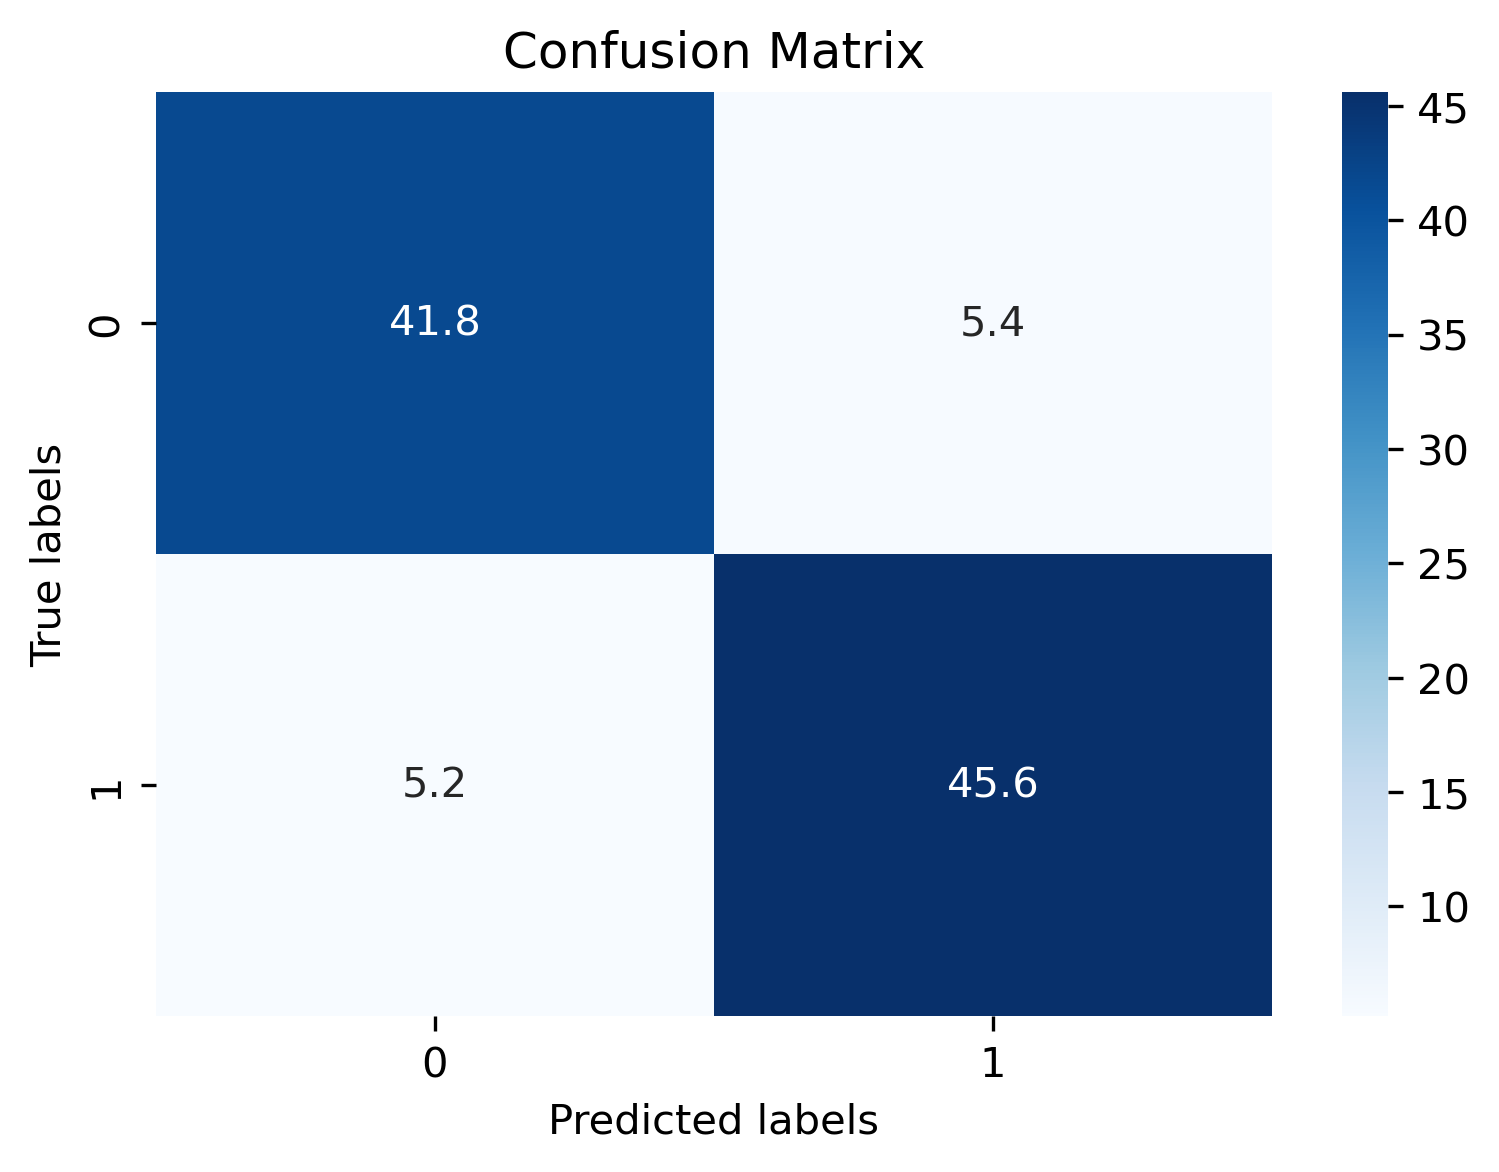

In [20]:
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_mat_ave, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# SHAP

In [21]:
explainer = shap.KernelExplainer(model.predict, test_dataset.X)

In [22]:
shap_values = explainer.shap_values(test_dataset.X)

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [37:57<00:00, 23.24s/it]


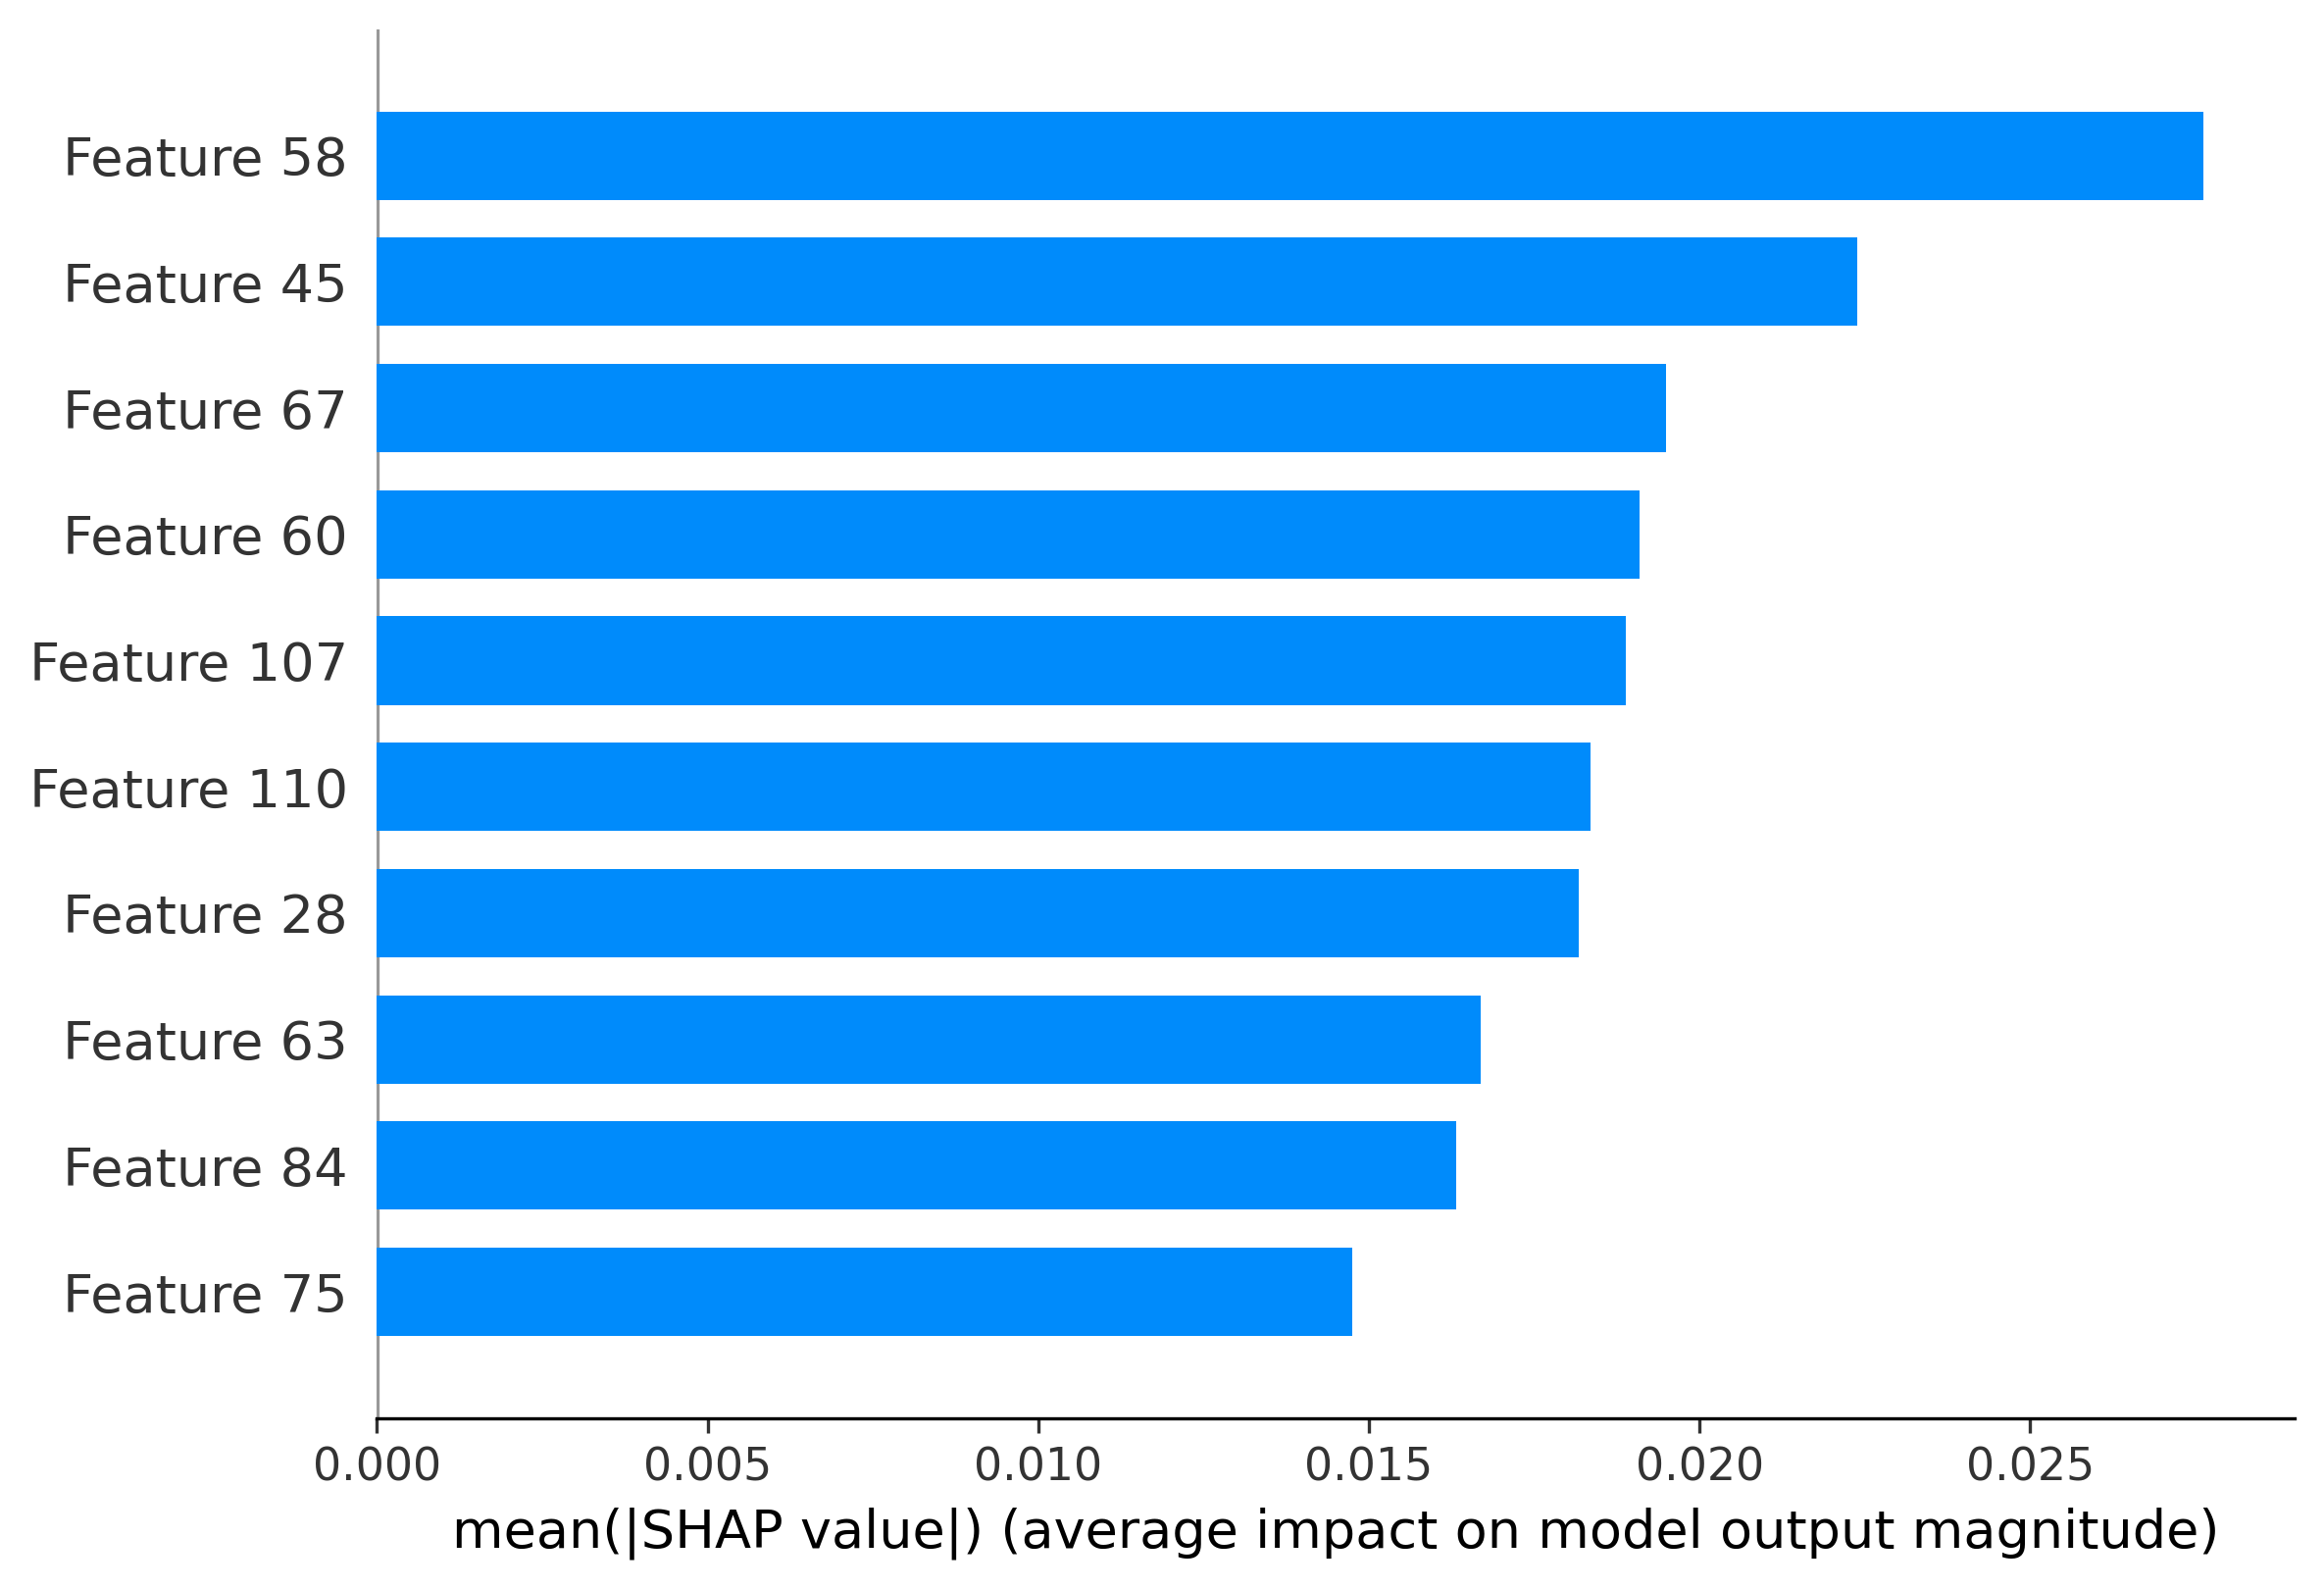

In [23]:
shap.summary_plot(shap_values, test_dataset.X, plot_type="bar", max_display=10)

In [30]:
data_maccs_mask

array([ 17,  19,  22,  23,  24,  25,  34,  36,  37,  38,  42,  43,  46,
        47,  49,  50,  51,  52,  53,  54,  56,  57,  59,  60,  61,  62,
        63,  64,  65,  66,  67,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166],
      dtype=int64)

In [27]:
MACCS = pd.read_csv('../../data/MACCS.csv',encoding='gb18030')

In [28]:
result = [MACCS['REMARK'][i-1] for i in data_maccs_mask] 

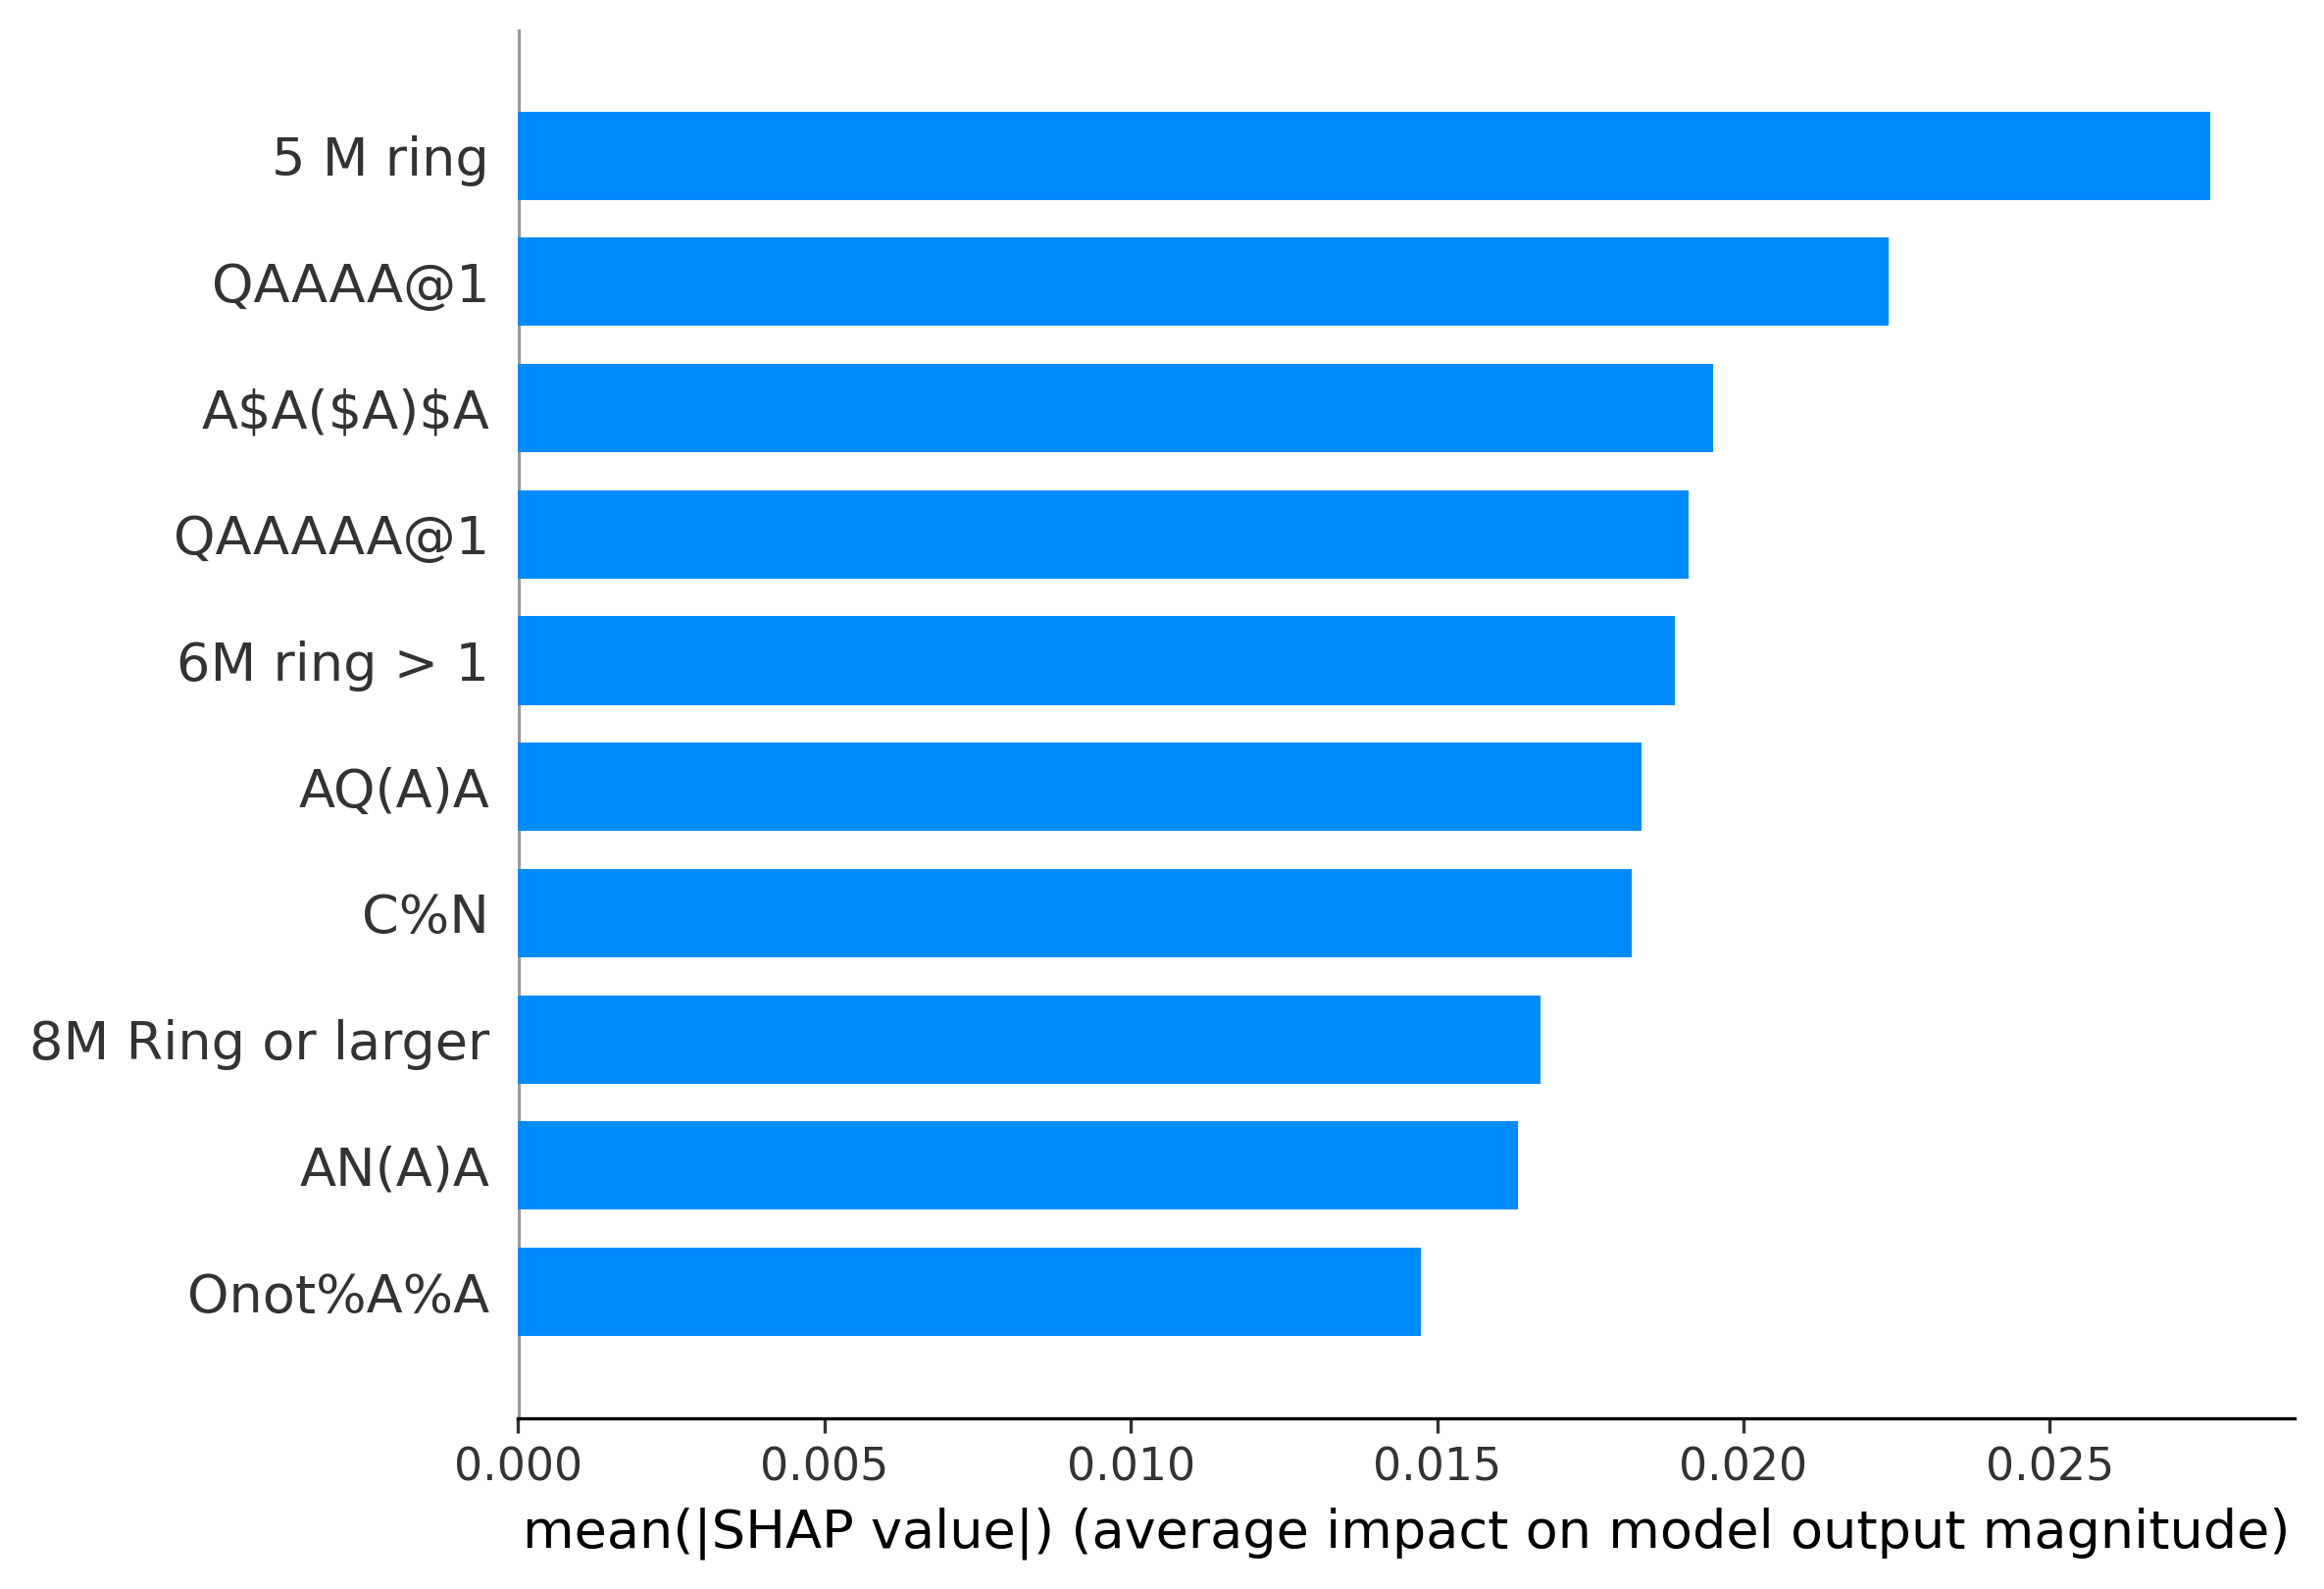

In [29]:
shap.summary_plot(shap_values, test_dataset.X, plot_type="bar", max_display=10,feature_names = result)

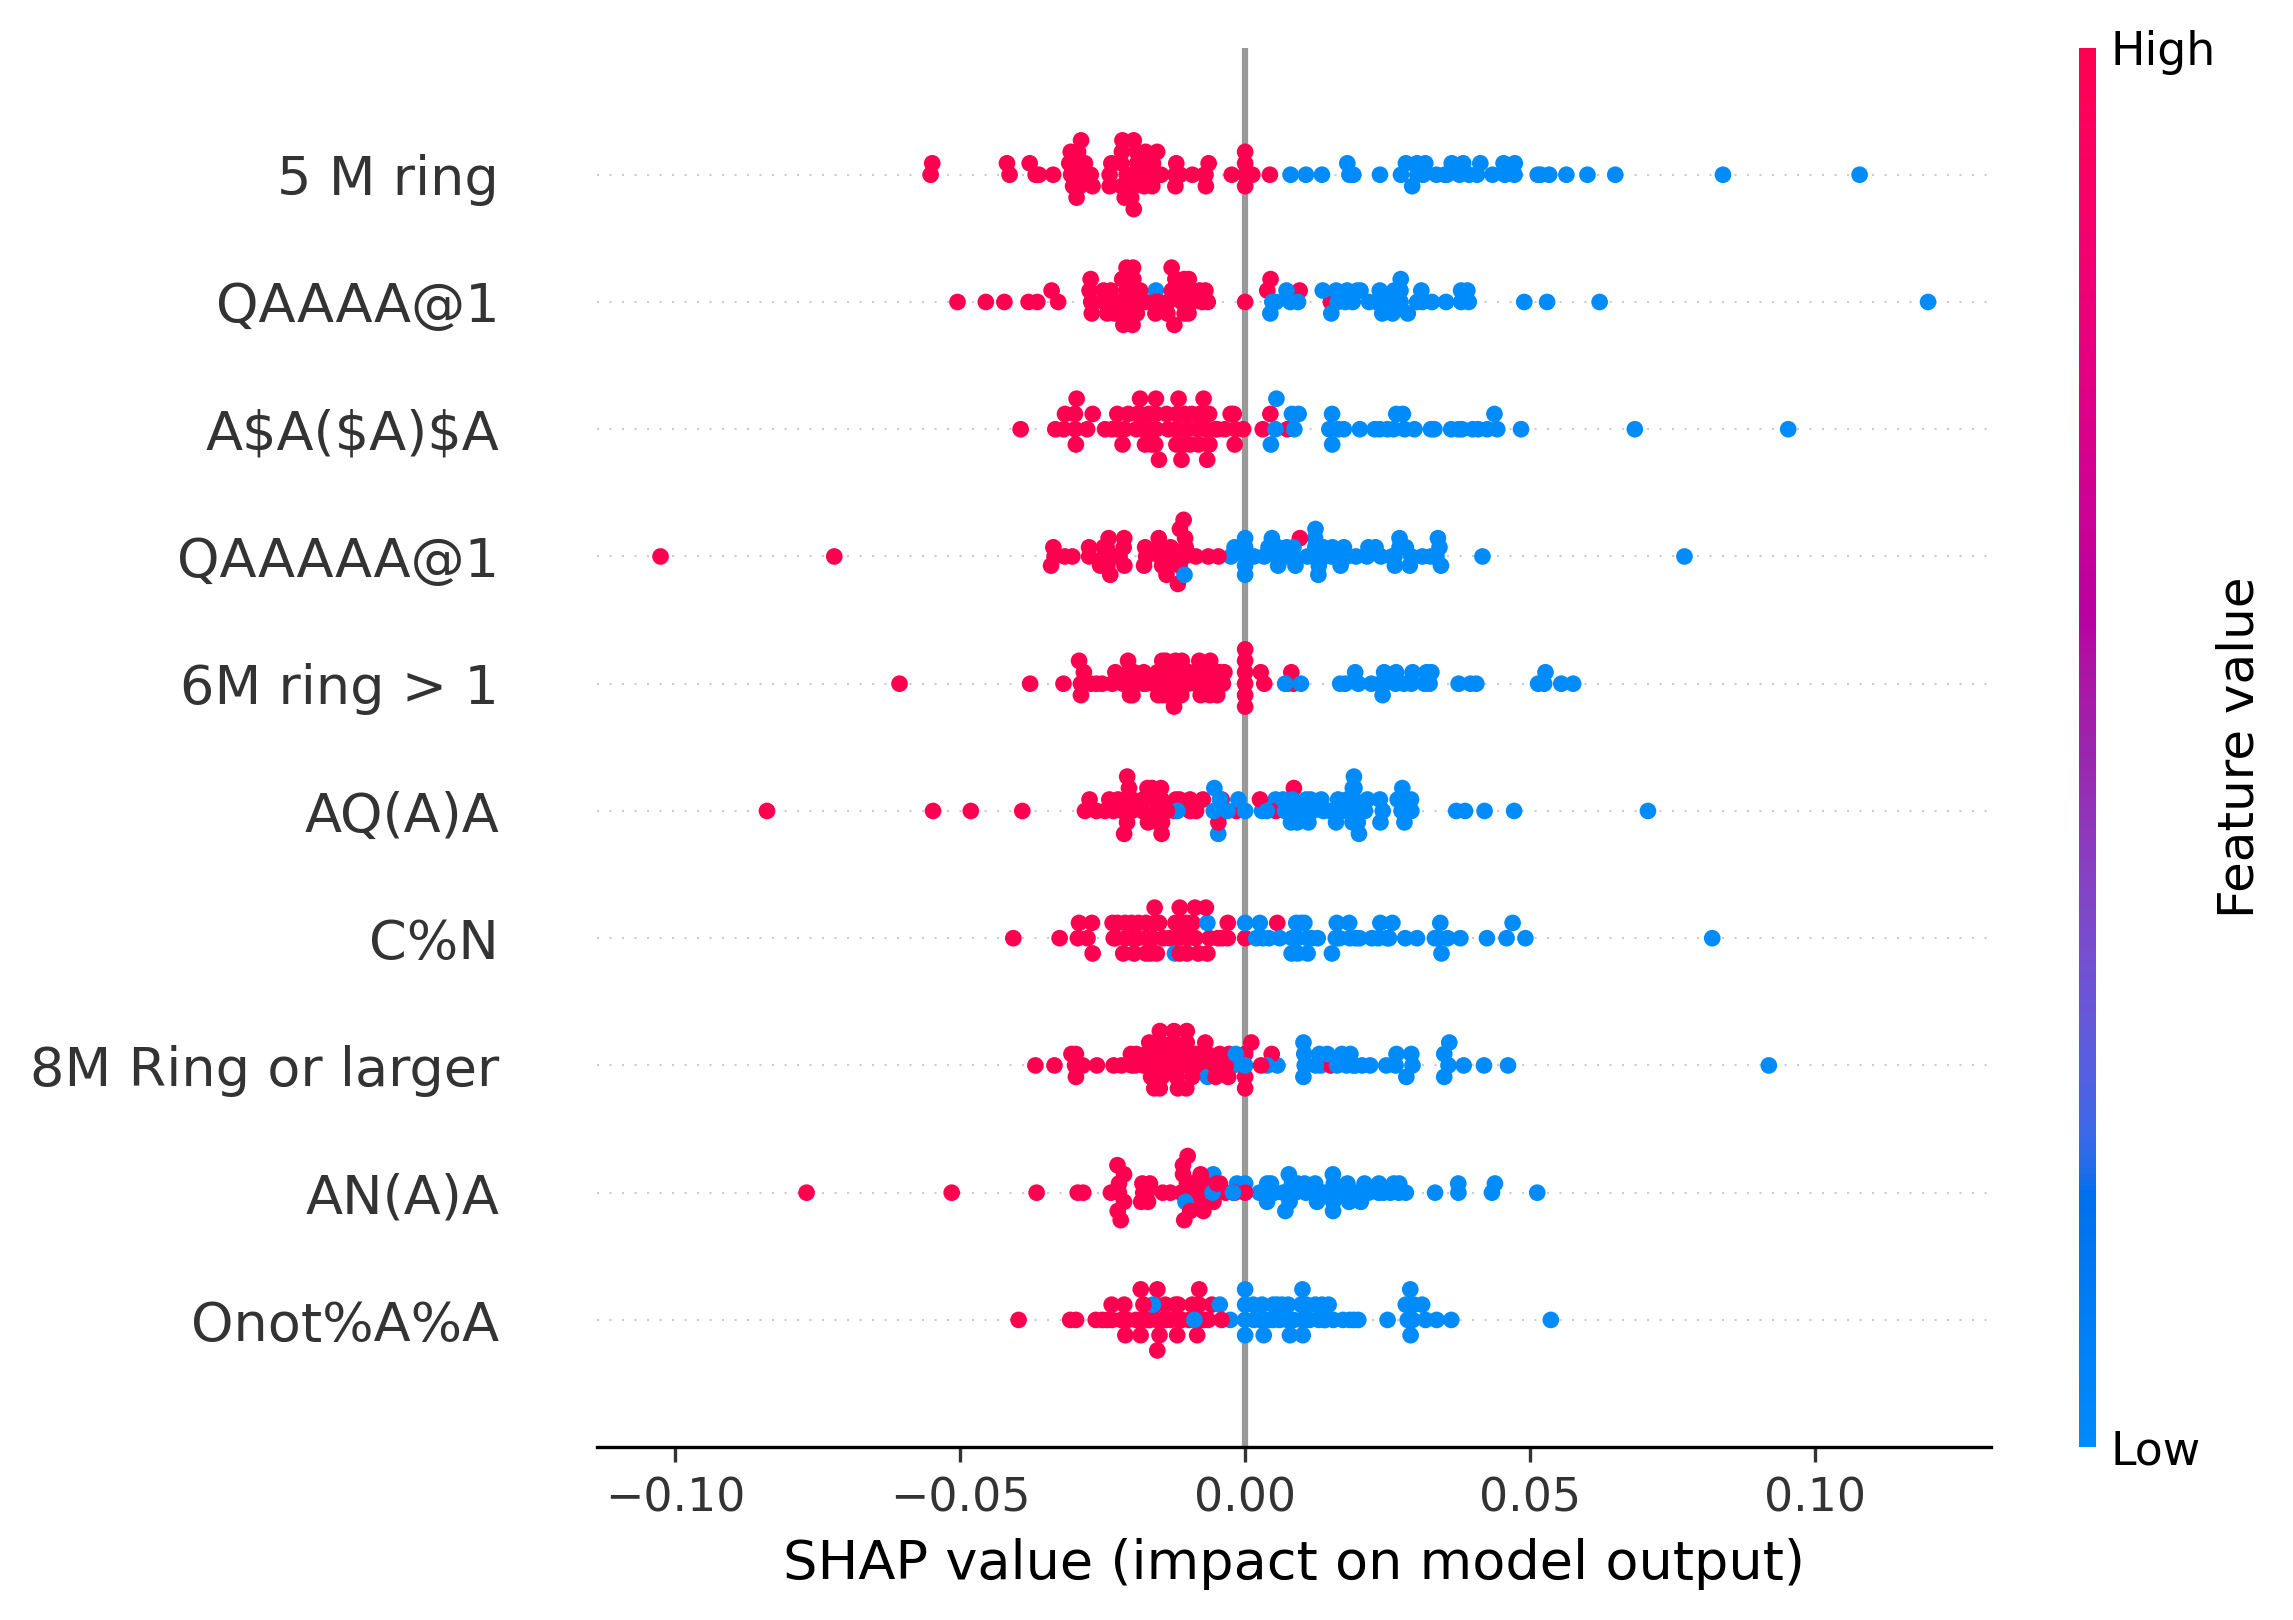

In [30]:
shap.summary_plot(shap_values, test_dataset.X,max_display=10,feature_names = result)